# Neural Network based analysis

In this phase we will train a couple of neural networks to see , how well they can predict diabetes prevalence

## Specifying the imports

In [40]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np

import warnings

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import l2


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix, ConfusionMatrixDisplay


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### General Settings

In [41]:
# Set display options 
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# ignore warnings
warnings.filterwarnings('ignore')

np.random.seed(42)


## Reading the Data

In [42]:
# Load BRFS csv into a dataframe
df = pd.read_csv('data/diabetes_012_health_indicators_BRFSS2015.csv')
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [43]:
df.shape

(253680, 22)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [45]:
numeric_features = ["BMI","MentHlth","PhysHlth"]
bin_clinical_features = ["HighBP","HighChol","CholCheck","Stroke","HeartDiseaseorAttack","DiffWalk","Sex"]
bin_lifestyle_features = ["Smoker","PhysActivity","Fruits","Veggies","HvyAlcoholConsump"]
ordinal_lifestyle_features = ["Education","Income","Age","GenHlth"]

## Preparing the Data

### During EDA Phase we have already established that the data
    1. Has no columns with missing values 
    2. Has no binary clinical features with Out of Range values 
    3. Has no binary lifestyle features with Out of Range values 
    4. Has no ordinal lifestyle features with Out of Range values

In [46]:
# Check for duplicate values 
dup_count = df.duplicated().sum()
print ("number of duplicate rows",dup_count)

# Remove the duplicates 
df =df.drop_duplicates()
df.shape

number of duplicate rows 23899


(229781, 22)

### Prepare the target variable

In [47]:
# 0 --> No Diabetes
# 1 --> Pre Diabetes
# 2 --> Diabetes
diabetes_labels = {0: 'No Diabetes', 1: 'Pre Diabetes', 2: 'Diabetes'}

#Create a new target variable to show presence of diabetes
df['Diabetes Prevalent'] = (df['Diabetes_012'] == 2).astype(int)

### Train/Test Split

In [48]:
# Lets use all the features for training 
total_features = numeric_features + bin_clinical_features + bin_lifestyle_features + ordinal_lifestyle_features

# Prepare the data
X = df[total_features]
y = df['Diabetes Prevalent']

# Split with 20% test size 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [49]:
# Scale all features using a Standard Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
# Define the model 
diabetes_model = Sequential([
    # Input layer
    Input(shape=(X_train_scaled.shape[1],)),
    
    # Hidden layer 1
    Dense(64, activation='relu', name='hidden1'),
    
    # Hidden layer 2
    Dense(32, activation='relu', name='hidden2'),
    
    # Output layer
    Dense(1, activation='sigmoid', name='output')
], name='DB_NN')


In [51]:
# Compile the model, and look for accuracy, precision, recall and auc scores 

diabetes_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

In [52]:
# Lets train the model now

start_time = time.time()

diabetes_history = diabetes_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    class_weight={0: 1, 1: 6}, # 85% non diabetic 15% diabetic ~5.5
    verbose=1
)

training_time = time.time() - start_time

# Predictions
y_pred_proba = diabetes_model.predict(X_test_scaled, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Metrics
diabetes_metrics = {
    'Model': 'Diabetes Model',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'Recall': recall_score(y_test, y_pred, zero_division=0),
    'F1-Score': f1_score(y_test, y_pred, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
    'Training Time (min)': training_time / 60
}
print(diabetes_metrics)

Epoch 1/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step - accuracy: 0.6867 - auc: 0.8052 - loss: 0.9365 - precision: 0.3000 - recall: 0.7944 - val_accuracy: 0.6847 - val_auc: 0.8105 - val_loss: 0.5580 - val_precision: 0.3057 - val_recall: 0.8135
Epoch 2/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - accuracy: 0.6900 - auc: 0.8136 - loss: 0.9184 - precision: 0.3042 - recall: 0.8056 - val_accuracy: 0.6981 - val_auc: 0.8119 - val_loss: 0.5449 - val_precision: 0.3135 - val_recall: 0.7960
Epoch 3/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 1s 445us/step - accuracy: 0.6920 - auc: 0.8148 - loss: 0.9158 - precision: 0.3055 - recall: 0.8041 - val_accuracy: 0.7035 - val_auc: 0.8127 - val_loss: 0.5293 - val_precision: 0.3165 - val_recall: 0.7872
Epoch 4/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 1s 443us/step - accuracy: 0.6925 - auc: 0.8161 - loss: 0.9130 - precision: 0.3062 - recall: 0.8065 - val_accuracy: 0.6990 - val_auc: 0.8118 - val_loss: 0.5313 - val_precision: 0.3138 - val_recall: 0.7933
Epoch 5/100


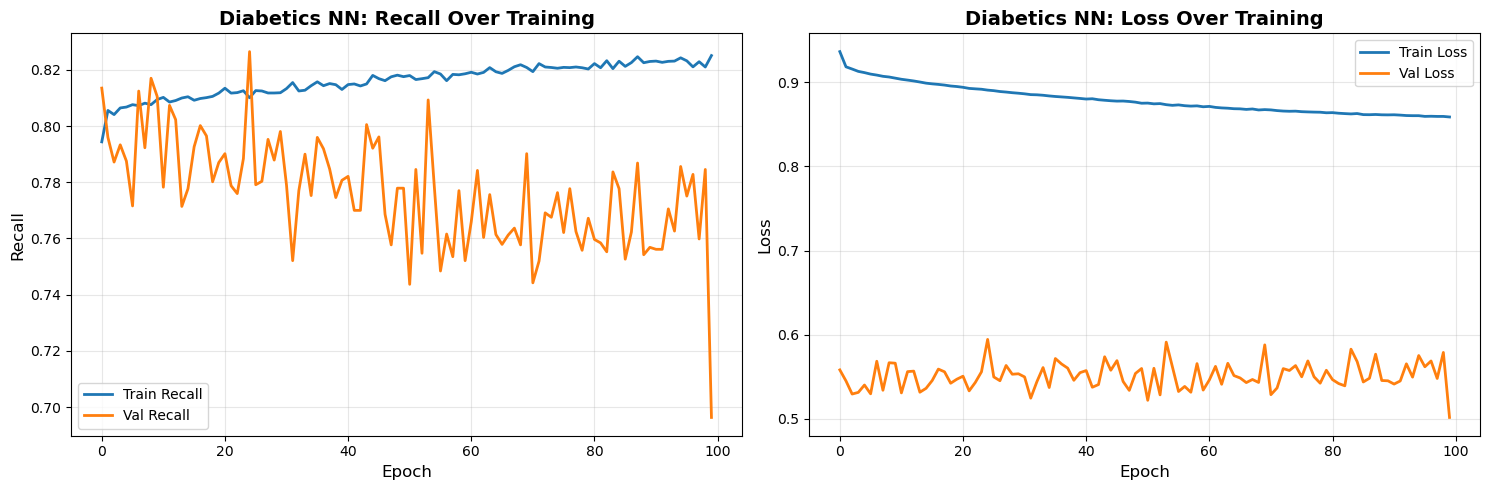

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Recall
axes[0].plot(diabetes_history.history['recall'], label='Train Recall', linewidth=2)
axes[0].plot(diabetes_history.history['val_recall'], label='Val Recall', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Recall', fontsize=12)
axes[0].set_title('Diabetics NN: Recall Over Training', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Loss
axes[1].plot(diabetes_history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(diabetes_history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Diabetics NN: Loss Over Training', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("images/diabetes_nn_training.png", dpi=300, bbox_inches='tight')
plt.show()

### Advanced Model with more layers

In [54]:
# Create a more advanced model with 5 hidden layers
diabetes_model_advanced = Sequential([
    # Input layer
    Input(shape=(X_train_scaled.shape[1],)),
    
    # Hidden layer 1
    Dense(256, activation='relu', 
          kernel_regularizer=l2(0.01),
          name='hidden1'),
    # Hidden layer 2
    Dense(128, activation='relu',
          kernel_regularizer=l2(0.01),
          name='hidden2'),
    # Hidden layer 3
    Dense(64, activation='relu',
          kernel_regularizer=l2(0.01),
          name='hidden3'),
    
    # Hidden layer 4
    Dense(32, activation='relu',
          name='hidden4'),
    
    # Hidden layer 5 
    Dense(16, activation='relu',
          name='hidden5'),
    
    # Output layer
    Dense(1, activation='sigmoid', name='output')
], name='Advanced_DB_NN')

In [62]:
# Compile the model, and look for accuracy, precision, recall and auc scores 

diabetes_model_advanced.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

In [63]:
# Lets train the model now

start_time = time.time()

diabetes_advanced_history = diabetes_model_advanced.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_test_scaled, y_test),
    class_weight={0: 1, 1: 6}, # 85% non diabetic 15% diabetic ~5.5
    verbose=1
)

training_time = time.time() - start_time

# Predictions
y_pred_proba = diabetes_model_advanced.predict(X_test_scaled, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Metrics
diabetes_advanced_metrics = {
    'Model': 'Diabetes Advanced Model',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'Recall': recall_score(y_test, y_pred, zero_division=0),
    'F1-Score': f1_score(y_test, y_pred, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
    'Training Time (min)': training_time / 60
}
print(diabetes_advanced_metrics)

Epoch 1/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6882 - auc: 0.8132 - loss: 0.9278 - precision: 0.3039 - recall: 0.8072 - val_accuracy: 0.6975 - val_auc: 0.8189 - val_loss: 0.5489 - val_precision: 0.3106 - val_recall: 0.8040
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6901 - auc: 0.8134 - loss: 0.9273 - precision: 0.3051 - recall: 0.8055 - val_accuracy: 0.7213 - val_auc: 0.8188 - val_loss: 0.5103 - val_precision: 0.3256 - val_recall: 0.7695
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6901 - auc: 0.8135 - loss: 0.9269 - precision: 0.3049 - recall: 0.8036 - val_accuracy: 0.6986 - val_auc: 0.8183 - val_loss: 0.5451 - val_precision: 0.3119 - val_recall: 0.8068
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6891 - auc: 0.8134 - loss: 0.9275 - precision: 0.3044 - recall: 0.8053 - val_accuracy: 0.6954 - val_auc: 0.8187 - val_loss: 0.5628 - val_precision: 0.3099 - val_recall: 0.8104
Epoch 5/100
719/719 ━━━━━━━━

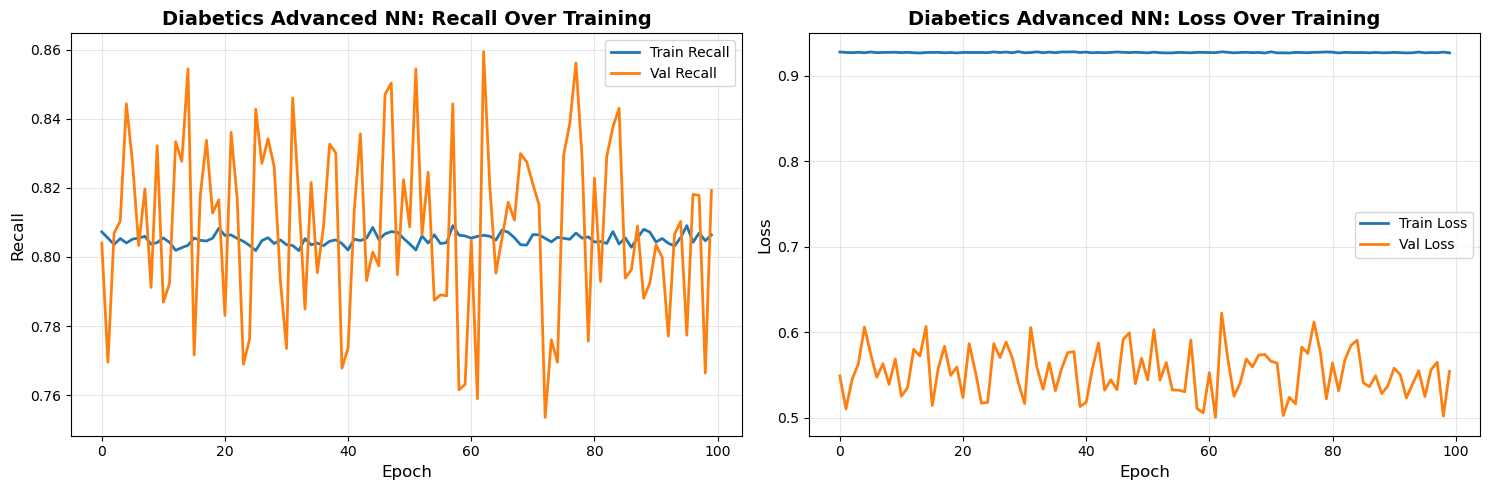

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Recall
axes[0].plot(diabetes_advanced_history.history['recall'], label='Train Recall', linewidth=2)
axes[0].plot(diabetes_advanced_history.history['val_recall'], label='Val Recall', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Recall', fontsize=12)
axes[0].set_title('Diabetics Advanced NN: Recall Over Training', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Loss
axes[1].plot(diabetes_advanced_history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(diabetes_advanced_history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Diabetics Advanced NN: Loss Over Training', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("images/diabetes_advanced_nn_training.png", dpi=300, bbox_inches='tight')
plt.show()